## Manifold learning

Для того, чтобы лучше понимать как работают автоэнкодеры, а так же чтобы в последствии генерировать из кодов что-то новое, стоит разобраться в том, что такое коды и как их можно интерпретировать.

Наши изображения цифр это элементы 28*28=784-мерного пространства, как и вообще любое монохромное изображение 28 на 28.
Однако среди всех изображений, изображения цифр занимают лишь ничтожную часть, абсолютное же большинство изображений это просто шум. 
С другой стороны, если вязть произвольное изображение цифры, то и все изображения из некоторой окрестности так же можно считать цифрой. С некоторыми немного более жесткими аргументами мы можем видеть, что они занимают подпространство более низкого измерения.

Если взять два произвольных изображения цифры, то в изначальном 784-мерном пространстве скорее всего можно найти непрерывную кривую, все точки вдоль которой можно так же считать цифрами (хотя бы изображений цифр одного лейбла), а вкупе с прерыдущим замечанием, то и все точки некоторой области вдоль этой кривой.

Таким образом в пространстве всех изображений есть некоторое подпространство меньшей размерности в области вокруг которого сосредоточились изображения цифр. То есть, если наша генеральная совокупность это все изображения цифр, которые могут быть нарисованы впринципе, то плотность вероятности встретить такую цифру в пределах области сильно выше, чем вне.

Одной из популярных теорий среди исследователей машинного обучения является **гипотеза многообразия** (manifold hypothesis) : **MNIST — это низкоразмерное многообразие, проходящее и изгибающееся в своем многомерном пространстве вложений**. Другая гипотеза, больше связанная с топологическим анализом данных, заключается в том, что **данные, подобные MNIST, состоят из пятен с выступами, похожими на щупальца, торчащими в окружающее пространство**.


Автоэнкодеры с размерностью кода k ищут k-мерное многообразие в пространстве объектов, которое наиболее полно передает все вариации в выборке. А сам код задает параметризацию этого многообразия. При этом энкодер сопоставляет объекту его параметр на многообразии, а декодер параметру сопоставляет точку в пространстве объектов.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему *mnist* цифры все более размытые при снижении размерности кода в автоэнкодерах).

### Простые примеры

Для того, чтобы лучше понять что такое ***manifold learning***, создадим простой двумерный датасет в виде кривой плюс шум и будем обучать на нем автоэнкодер

In [4]:
# Импорт необходимых библиотек
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

from sklearn.decomposition import PCA

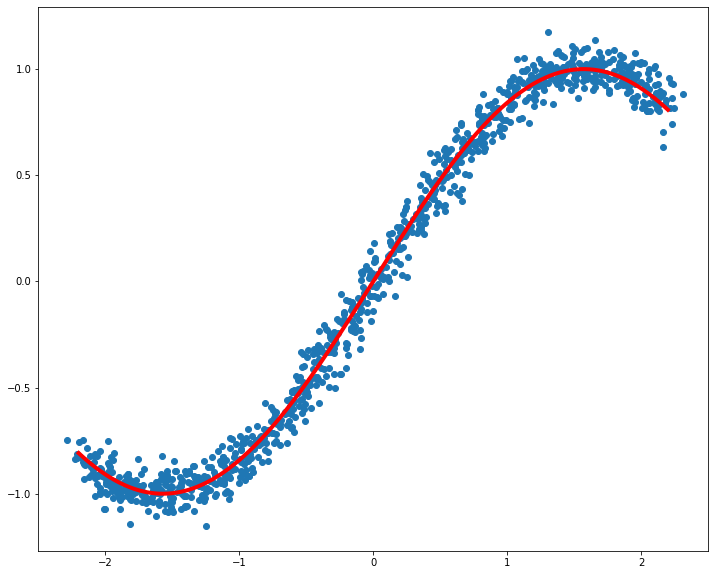

In [5]:
# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.sin(x1)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)


На картинке выше синие точки - данные, а красная кривая - многообразие определяющее наши данные

#### Линейный сжимающий автоэнкодер (PCE)

Самый простой автоэнкодер - это двухслойный сжимающий автоэнкодер с линейными функциями активации (больше слоев не имеет смысла при линейной активации).

Такой автоэнкодер ищет аффинное (линейное со сдвигом) подпространство в пространстве объектов, которое описывает наибольшую вариацию в объектах, тоже самое делает и ***PCA*** (метод главных компонент) и оба они находят одно и тоже подпространство

In [ ]:
def linear_ae():
    input_dots = Input((2,))
    code = Dense(1, activation='linear')(input_dots)
    out  = Dense(2, activation='linear')(code)

    ae = Model(input_dots, out)
    return ae

ae = linear_ae()
ae.compile(Adam(0.01), 'mse')

print(ae.summary())

ae.fit(dots, dots, epochs=15, batch_size=30, verbose=0)

In [ ]:
# Применение линейного автоэнкодера
pdots = ae.predict(dots, batch_size=30)
vpdots = pdots[idxs]

# Применения PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

In [ ]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='white', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots[:,0], vpdots[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)


На картинке выше:
* белая линия - многообразие в которое переходят синие точки данных после автоэнкодера,
то есть попытка автоэнкодера построить многообразие, определяющее больше всего вариации в данных
* оранжевая линия - многообразие в которое переходят синие точки данных после PCA
* разноцветные кружки - точки, которые переходят в зведочки соответствующего цвета после автоэнкодера
* разноцветные звездочки - соответственно образы кружков после автоэнкодера